In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(lubridate)
options(repr.matrix.max.rows = 6)


# 1. Data Description
The dataset consists of two CSV files tracking player activity on a MineCraft research server from April to September 2024.
## CSV File 1: players.csv
|Variable|Type|Description|Summary Statistics|
|:-------|:--:|:---------:|:----------------:|
|experience|Categorical|Player skill level (Beginner, Amateur, Regular, Veteran, Pro)| 5 levels|
|subscribe|Boolean|Newsletter Subscription Status|TRUE: 78%, FALSE: 22%|
|hashedEmail|Text|Unique Player identifier (hashed)|200 unique players|
|played_hours|Numeric|Total hours played before joining server| Mean: 11.39, Median: 0.20 Max: 223.10|
|name|Text|Player Username|200 unique names|
|gender|Categorical|Player gender identity|7 categories (Male: 74%, Female: 14%, etc.)|
|Age|Numeric|Player age in years|Mean: 22.18, Range: 9-58, 2 missing values|


## CSV File 2: sessions.csv
|Variable|Type|Description|Summary Statistics|
|:-------|:--:|:---------:|:----------------:|
|hashedEmail|Text|Player identifier linking to players.csv| 2,006 sesions total|
|start_time|DateTime|Session start timestamp (DD/MM/YYYY HH:MM)|Range: Apr 2024 - Sep 2024|
|end_time|DateTime|Session end timestamp| 3 missing values|
|original_start_time|Numeric| Unix Timestamp for start time| scientific notation format|
|original_end_time|Numeric|Unix timestamp for end time| scientific notation format|


## Notable Data Quality Issues:
- 3 sesions have missing end_time values
- 2 players have missing Age values ("NA")
- Date format requires parsing for analysis
- Highly skewed played hours distribution with a median of 0.20 and a mean of 11.39)

# 2. Research Question
## Broad Question (Question 3)
I am interested in demand forecasting, namely, which time windows are most likely to have large numbers of players playing at the same time. This is because we need to ensure that the number of licenses on hand is sufficiently large to accomodate all parallel players with high probability.
## Specific Research Question
Can time-based features (hour of day, day of week, month) and player characteristics (experience level, previous play time) predict the number of concurrent players in hourly time windows on the Minecraft research server?
## Variable Definitions
### Response Variable 
concurrent_players: number of palyers with overlapping sessions in each hourly time window which will be derived from session start/end times)
### Explanatory Variables
- hour : hour of the day (0-23)
- day_of_week: weekday (Mon - Sun)
- month: Month of year
- avg_experience: Average player experience level
- total_sesions_prev_week: sessions in previous week
## How the Data Addresses the Question
The sessions.csv file containts timestamps for when each player starts and ends their play sesion. By analyzing these timestamps we can:
1. Calculate concurrent players: For any given time window, we can count how many sessions overlap.
2. Extract time window patterns: Identify peak hours, days, and seasonal trends in player activity.
3. Incorporate player characteristics: join with players.csv to understand if experienced players play at different times than beginners.
4. Build predictive models: Use historical patterns to forecast future demand.

## Data Wrangling Required
- Parse datetime strings into proper timestamp format
- create hourly time winows across the entire data period
- claculate concurrent player counts for each time window
- extract temporal featues (hour, day, month, week number)
- Join session data with player characteristics
- Handle missing end_time values (na.rm = True maybe)


# 3. Exploratory Data Analysis
The following is a basic exploration from what is asked in the rubric

In [2]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")


head(players)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [19]:
sessions_tidy <- sessions |>
    mutate(
        start_time = dmy_hm(start_time),
        end_time = dmy_hm(end_time)) |>
    filter(!is.na(end_time))
# Players data set is already tidy by definition:
# Each row is one player (observation) each column is one variable)
players_tidy <- players

dim(players_tidy)
dim(sessions_tidy)
sessions_tidy

[1] 196   7

[1] 1533    5

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12


In [9]:
# Calculate means for quantitavtive variables
mean_table <- players_tidy |>
    summarise(
        mean_played_hours = mean(played_hours, na.rm = TRUE),
        mean_age = mean(Age, na.rm = TRUE)
        ) |>
    pivot_longer(
        cols = everything(),
        names_to = "Variable",
        values_to = "Mean"
        ) |>
    mutate(
        Variable = str_remove(Variable, "mean_"),
        Mean = round(Mean, 2)
        )
# Display the table
print(mean_table)

# A tibble: 2 × 2
  Variable      Mean
  <chr>        <dbl>
1 played_hours  5.85
2 age          21.1 


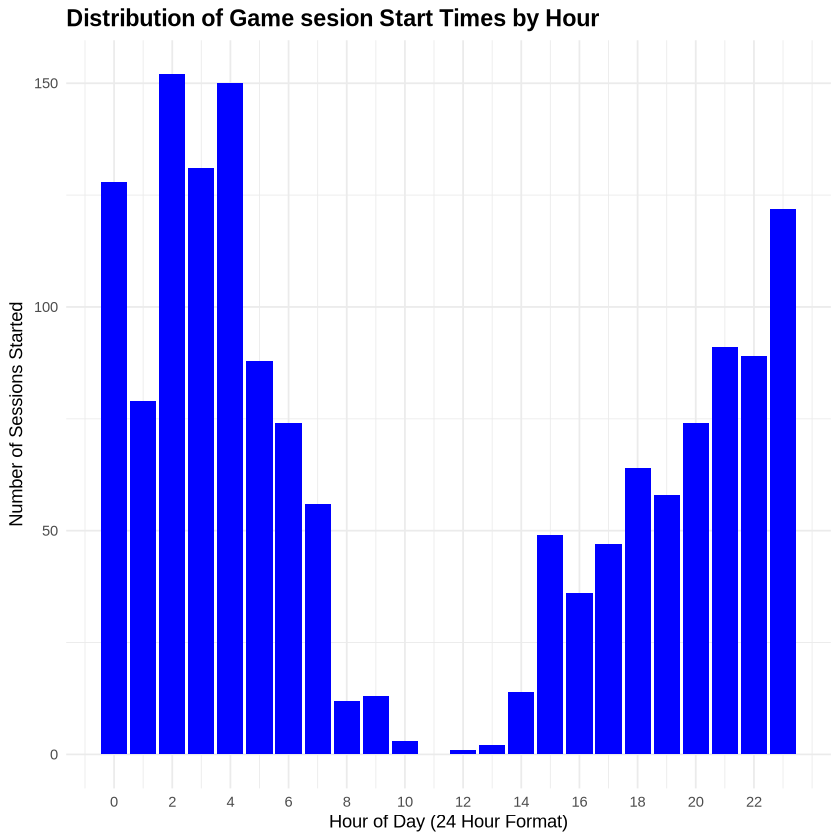

In [23]:
# Exploratory Visualizations
# Vsiaulization 1: Session Start Times by Hour of Day
hourly_sessions <- sessions_tidy |>
    mutate(hour = hour(start_time)) |>
    count(hour)
hourly_plot <- ggplot(hourly_sessions, aes(x = hour, y = n)) +
    geom_col(fill = "blue") +
    labs(
        title = "Distribution of Game sesion Start Times by Hour",
        x = "Hour of Day (24 Hour Format)",
        y = "Number of Sessions Started",
        ) +
    scale_x_continuous(breaks = seq(0, 23, 2)) +
    theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 10),
    axis.title = element_text(size = 11)
  )
hourly_plot

# Insights relevant to predicting concurrent players
- Clear evening peak: Players log in after work/school, suggesting these hours will have the highest concurrent player counts.
- Late night / early morning activity : High activity from night owl players create a secondary peak demand period
- Day time minimum: lowest activity aligns with work/school hours - ideal time for a server maintenance.
- Hour of day is a strong predictior : This pronounced pattern indicates hour should be a key feature in our regression model.

# A tibble: 7 × 2
  day_of_week     n
  <ord>       <int>
1 Monday        207
2 Tuesday       203
3 Wednesday     210
4 Thursday      223
5 Friday        181
6 Saturday      261
7 Sunday        248


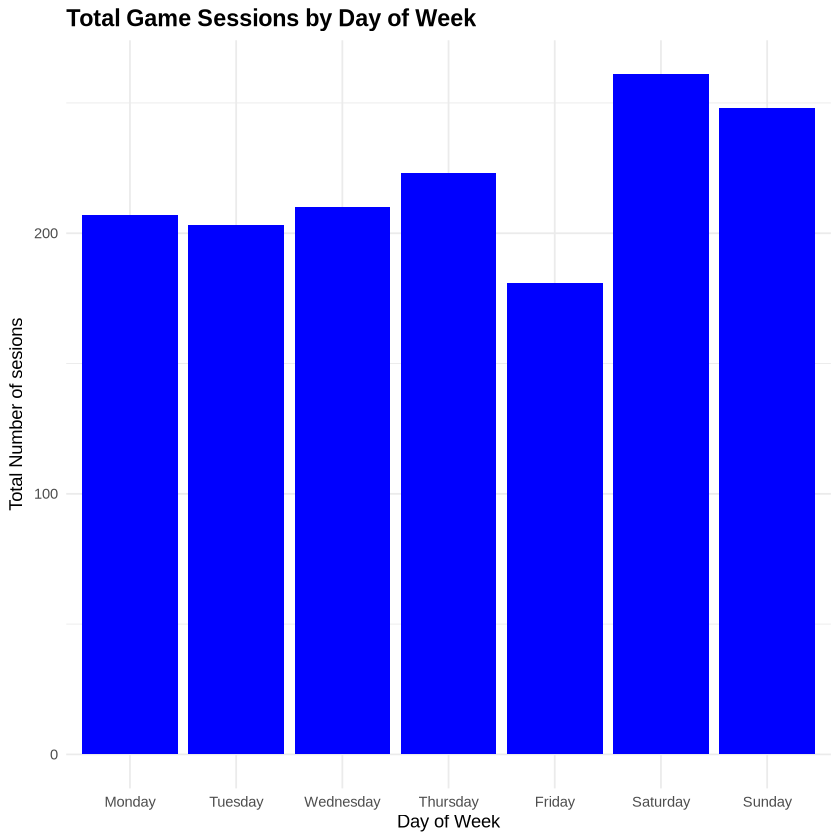

In [22]:
# Visualization 2: Sessions by Day of Week
daily_sessions <- sessions_tidy |>
    mutate(
        day_of_week = wday(start_time, label = TRUE, abbr = FALSE)
        ) |>
    mutate(
        day_of_week = factor(day_of_week, 
                             levels = c("Monday", "Tuesday", "Wednesday", 
                                   "Thursday", "Friday", "Saturday", "Sunday"))
        ) |>
    arrange(day_of_week) |>
    count(day_of_week) 
print(daily_sessions)
daily_plot <- ggplot(daily_sessions, aes(x = day_of_week, y = n)) +
    geom_col(fill = 'blue') +
    labs(
        title = "Total Game Sessions by Day of Week",
        x = "Day of Week",
        y = "Total Number of sesions"
        ) +
    theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 10),
    axis.title = element_text(size = 11)
  )
daily_plot

# Insights
- Weekend peak: Saturday shows ~20% more sesions than monday, indicating higher concurrent players on weekends.
- Low friday session count: this may be because players are busy with end-of-week work or people go out socializing on friday nights.
- Clear categorical predictor: the 44% variance between friday and saturday makes day_of_week essential for our prediction model.
  

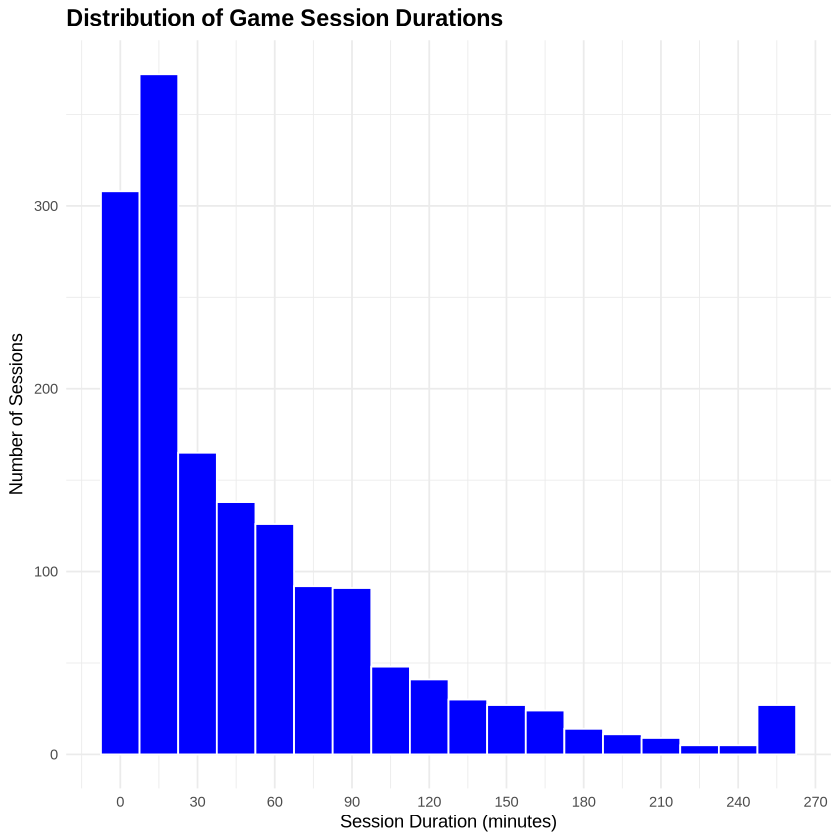

In [26]:
# Visualization 3: Session Duration Distribution
session_durations <- sessions_tidy |>
  mutate(
    duration_minutes = as.numeric(difftime(end_time, start_time, units = "mins"))
  ) |>
  filter(duration_minutes > 0 & duration_minutes < 600)  # Remove outliers/errors

ggplot(session_durations, aes(x = duration_minutes)) +
  geom_histogram(binwidth = 15, fill = "blue", color = "white") +
  labs(
    title = "Distribution of Game Session Durations",
    x = "Session Duration (minutes)",
    y = "Number of Sessions") +
  scale_x_continuous(breaks = seq(0, 300, 30)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 10),
    axis.title = element_text(size = 11)
  )

# Insights
- most sessions are short (<30 min): Many players log in briefly suggesting rapid turnover that could create concurrent player spikes during peak hours.
- 30-60 minute sessions are common: Core engaged gameplay period means players who start during peak hours will likely still be online in the next time window period.
- Long Tail distribution: someplayers stay for 2-4+ hours, maintaining sustained concurrent player counts and base-level demand
- This means we need to consider not just session starts but also overlapping sesions - a lag feature of "players from prev hour" will be important.

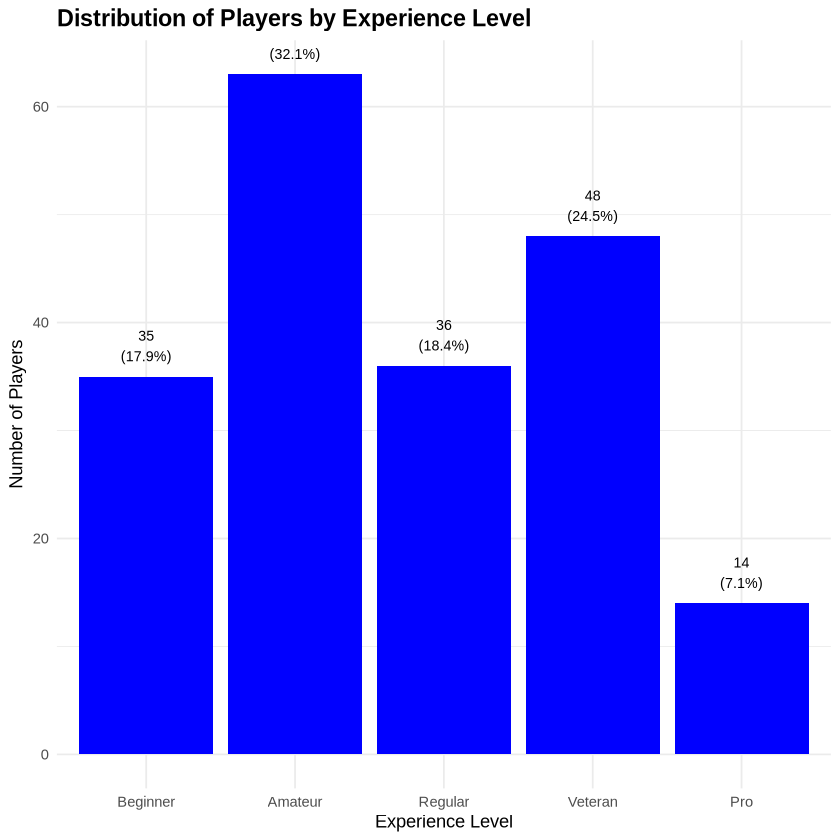

In [28]:
# Visualization 4: Player Experience Level Distribution
experience_counts <- players_tidy |>
  count(experience) |>
  mutate(
    experience = factor(experience, 
                       levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")),
    percentage = round(n / sum(n) * 100, 1)
  )


ggplot(experience_counts, aes(x = experience, y = n)) +
  geom_col(fill = "blue") +
  geom_text(aes(label = paste0(n, "
(", percentage, "%)")), 
            vjust = -0.5, size = 3) +
  labs(
    title = "Distribution of Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players",
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 10),
    axis.title = element_text(size = 11)
  )

# Insights
- Veterans, Amateurs, and Regulars comprise majority of the playerbase, suggesting the server attracts experienced gamers who have more consistent play patterns.
- Limited beginner presence: Fewer newcomers means less unpredictable behavior and more stable concurrent player patterns.
- Experience level could be incorporated as an explanatory variable if different skill levels show different time-of-day preferences
- In the group phase, we could analyze if veterans play at different hours than beginners which could improve our prediction model.

# 4. Methods and Plan
## Proposed Method
Multiple Linear Regression
### Why it was chosen
1. Regression Problem: we are predicting a continuous numeric outcome (number of concurrent players), making this a regression task rather than classification.
2. Interpretability: Linear reg coefficients directly show us how each time feature affects player counts, which is valuable in making resource decisions.
3. Multiple Predictors: We have several time-based and player characteristic features that can jointly predict concurrent players, which multiple regression handles well.
4. Baseline Comparison: Linear reg provides a strong baseline before testing more complex methods in the future.

## Required Assumptions
1. Linearity: The relationship between predictors (hour, day) and concurrent players is approximately linear (may need polynomial terms for hour)
2. Independence: Time windows are independent observations (potential concern due to temporal autocorrelation - consecutive hours may be correlated)
3. Predictor variables aren't highly correlated with each other (need to check VIF)

## Potential Limitations
1. Temporal Autocorrelation:Player counts in consecutive hours are likely correlated (players don't instantly appear/disappear). This violates independence assumption.
2. Non-linear Relationships:Hour of day likely has non-linear effects (quadratic or cyclical patterns).
3. Limited Historical Data:Only 6 months of data may not capture long-term seasonality or special events.
4. Outliers & Spikes: Special events or coordinated play sessions could create outliers that skew predictions.

## Model Comparison and Selection
### Evaluation Metrics:

- RMSE (Root Mean Squared Error): Primary metric - average prediction error in number of players
- MAE (Mean Absolute Error): More robust to outliers than RMSE
- R² Score: Proportion of variance explained by the model
- MAPE (Mean Absolute Percentage Error): Relative error for business interpretation
### Model Comparison Strategy:
1. Baseline: Simple linear regression with hour and day_of_week
2. Enhanced: Add polynomial features, lag variables, and player characteristics
3. Select model with lowest RMSE on test set while maintaining interpretability

## Data Processing Plan
### Train-Test Split
- Split Method: Temporal split (not random) to respect time series nature
- Training Set: April - July 2024 (~70% of data)
- Test Set: August - September 2024 (~30% of data)
- Rationale: Test on most recent data to simulate real forecasting scenario
- No shuffling: Preserve temporal ordering to avoid data leakage
### Model Training & Validation
- Use training set only for fitting the model
- Optionally: 5-fold time series cross-validation on training set for hyperparameter tuning
- Train multiple model variants (baseline, enhanced, alternative)
- Track training metrics but don't use for final selection
### Model Evaluation
- Evaluate all models on the held-out test set
- Calculate RMSE, MAE, R², and MAPE
- Create residual plots to check assumptions
- Analyze prediction errors by hour and day to identify systematic biases
- Select best model based on test RMSE and business interpretability
### Validation
We'll use a simple train-test split rather than a train-validation-test because:
- we have limited data which makes splitting it further inefficeient.

## Link to github